# Lab Four: Evaluation and Multi-Layer Perceptron

#### Machine Learning in Python

Will Lacey - 45906124 - <strong>CSE7324</strong>
<br>
Roger Wong - 43867412 - <strong>CSE5324</strong>

## Preparation (15 points total)
<em>
<strong>[5 points]</strong> (mostly the same processes as from previous lab) Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the task is and what parties would be interested in the results. How well would your prediction algorithm need to perform to be considered useful by interested parties?
</em>



This dataset is a collection of images of alphabets from the American Sign Language. There are 29 classes associated with it, of which 26 are for the letters A-Z and 3 classes for SPACE, DELETE, and NOTHING. There are 3000 images for each class leading to this dataset containing over 80,000 images. For this lab, we are taking only a subset of these images. We will be using 100 images of each class which then combines into 2900 images overall with 29 classes. The data in this dataset is a very good representation of the American Sign Language. All the images vary in lightning, position of the hand, and angles. With such a varied dataset to train on, our program should be able to classify each hand no matter the variables.
The data can be very useful in training a machine to learn American Sign Language. Over 5% of the world’s population, 466 million people, have disabling hearing loss as stated by the World Health Organization. WHO also estimated that the number of people with hearing loss would increase in the later years. The end goal prediction task for this set is for the program to tell which class does each image represent. If we can produce an adequate measure of success for our dataset, third parties such as WHO, will be able to benefit from us. Communication between the hearing and non-hearing will be much easier.
 
Now how do we determine if our machine learning algorithm is a success for this dataset. If our algorithm works well, we expect our success rate to be better than random guessing. Since there are 29 classes, a random guess would be right 3.4% of the time. Although we can’t achieve a 100% success rate, we hope to be at least above 90%. The people who have use of our case will be those of hearing. Since non-hearing will understand sign language and have no need for this algorithm, those with hearing will be able to communicate more effectively. They will have an easier method of understanding sign language.
It would be okay for us to have some false negatives and false positives in classification since most humans can fill in the blanks given enough information. Although if our algorithm provides wrong classification too many times, some people might find it easier to manually type what they want to say so there is a balance between our algorithm being worth their time or just an encumbrance.

<img src='NIDCD-ASL-hands-2014.jpg' width="250">

#### Import Modules and Initialization

Before we begin, let's import essential packages for data analysis

In [2]:
import cv2
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from random import randint
from scipy.optimize import fmin_bfgs
from scipy.optimize import fmin_l_bfgs_b
from scipy.special import expit
import seaborn as sns
import skimage
from sklearn.base import BaseEstimator
import skimage.transform
import sklearn.datasets
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import sys

import warnings
warnings.simplefilter('ignore')

<em>
    <strong> [10 points]</strong> (mostly the same processes as from lab one) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification (include a description of any newly formed variables you created).
</em>

The following cell declares a function to load, normalize, and linearize images from the <strong>asl_alphabet</strong> dataset. 

In [3]:
def load_images(asl_classes, count, size):
    img_list = []
    for class_name in asl_classes:
        for i in range(count):
            img_path_string = 'asl_alphabet/'+class_name+'/'+class_name+str(i+1)+'.jpg'
            img = cv2.imread(img_path_string) # opens image using CV2
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts image to grayscale
            img = skimage.transform.resize(img, (size, size), mode='constant') # resizes image
            img = np.array(img*256, dtype=np.uint8)
            img = img.flatten()
            img_list.append(img)
        sys.stderr.write('\rClass %s done' % class_name)
        sys.stderr.flush()
    return img_list

Now that our loading function is defined, we may now load in the images. This takes about a minute.

In [4]:
%%time

number_of_images = 100

img_size = 32

asl_classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
               'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 
               'del', 'space', 'nothing'
]

class_list = load_images(asl_classes, number_of_images, img_size)

Class nothing done

CPU times: user 6.24 s, sys: 997 ms, total: 7.24 s
Wall time: 7.95 s


With our loaded images, we are going to create a <strong>sklearn Bunch</strong> object to better organize our data. The object will contain a <strong>data</strong>, <strong>target</strong>, <strong>target_values</strong>, and <strong>target_names</strong> numpy array. These arrays will contain the essential data needed to perform data analysis and training for our neural network. 

In further detail, here's a description of each variable within our <strong>sklearn Bunch</strong> object.
<ul>
    <li><strong>data</strong> - The ASL image dataset; linearized into numpy vectors; the image set has been transformed into <strong>img_size</strong> number of pixels </li>
    <li><strong>target</strong> - The ASL image dataset associated class names; each instance is a class name which can be mapped to the corresponding image vector</li>
    <li><strong>target_values</strong> - The ASL image dataset associated class values; each instance is a class value which can be mapped to the corresponding image vector and target class</li>
    <li><strong>target_names</strong> - A list of class names present in the ASL image dataset; contains the alphabet and three additional classes</li>
</ul>

In [5]:
class_titles = []
for i in range(len(asl_classes)):
    for j in range(number_of_images):
        class_titles.append(asl_classes[i])
        
class_values = []
for i in range(len(class_titles)):
    class_values.append(asl_classes.index(class_titles[i]))
        
ds = sklearn.datasets.base.Bunch(
    data = np.array(class_list),
    target = np.array(class_titles),
    target_values = np.array(class_values),
    target_names = np.array(asl_classes)
)

del class_list
del class_titles
del class_values
del asl_classes

print('Shape of data:', ds.data.shape)
print('Shape of target:', ds.target.shape)
print('Shape of target_values:', ds.target_values.shape)
print('Shape of target_names:', ds.target_names.shape)

Shape of data: (2900, 1024)
Shape of target: (2900,)
Shape of target_values: (2900,)
Shape of target_names: (29,)


Let's take a quick look at our different classes using our <strong>plot_gallery</strong> function from Lab2.

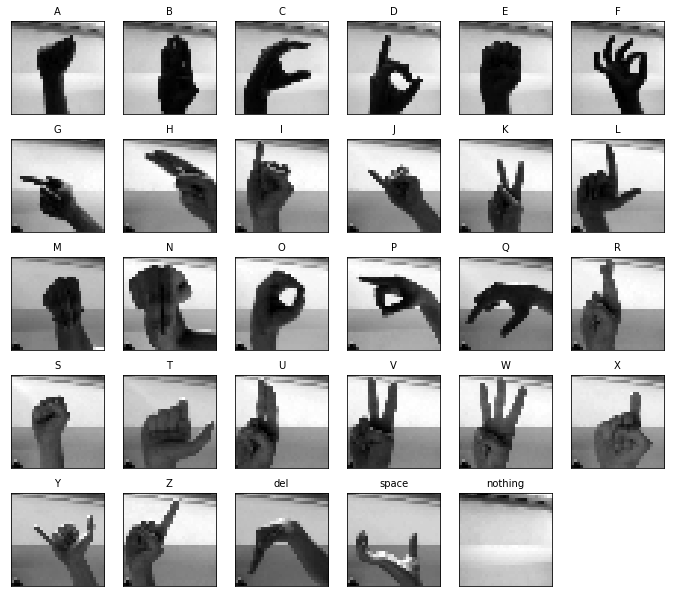

In [6]:
# a similar plotting function as seen in class; selects images from dataset
def plot_gallery(images, titles, random=False, n_row=5, n_col=6):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.9, top=.70, hspace=.1)
    for i in range(n_row * n_col):
        if i != (n_row * n_col - 1):
            plt.subplot(n_row, n_col, i + 1)
            if random:
                index = randint(1, len(images)-1)
            else:
                index =int(i * len(ds.data) / 29)
            plt.imshow(images[index].reshape((img_size, img_size)), cmap=plt.cm.gray)
            plt.title(titles[index], size=10)
            plt.xticks(())
            plt.yticks(())

        
plot_gallery(images=ds.data, titles=ds.target) 

In observing our different hand signs, we notice that several of the classes are similar. Most particularly, we see that the similarity between M and N make the two classes difficult to differentiate. Additionally, classes R, U and X are not the easiest to decipher as well. This will ultimately lower the efficiency of our neural net. Eventually, this problem may be addressed when we learn better image processing techniques in the course.

## Evaluation (30 points total)
<em> 
    <strong>[15 points]</strong> Choose and explain what metric(s) you will use to evaluate your algorithm’s generalization performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why does the metric evaluate performance in terms of the business case you argued for. Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
</em>



Our dataset consists of 2900 images. Each class has 100 images representing them. Normalization and reshaping are done equally among all images. All classes should be equally weighted in our opinion since each class is frequently used in ASL. This also means we don’t need to use a confusion matrix. We converted each class label into numbers. For example, the class label ‘A’ is now represented to be “0”. The evaluation metric we are using for our data set is sklearn’s accuracy_score. The accuracy_score is a multilabel classification that computes subset accuracy. The set of labels predicted for a sample must exactly match the corresponding set of labels in the y_test_true. Recall, precision, and f1_score are better suited towards datasets with unequal amounts of class distributions. 

<em>
    <strong>[15 points]</strong> Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time. Convince the reader that your cross validation method is a realistic mirroring of how an algorithm would be used in practice.
    <br>
    <br>
    Important: You should use your chosen evaluation criteria and chosen method for dividing train/test data throughout the report. For example, arguing that f-score is the best evaluation method, but then using accuracy in a grid search will be regarded as a conceptual error and graded accordingly. 
</em>


We will be using Stratified K fold cross validation with 10 folds. We aren’t using time series data so continuous training and testing sets across time won’t be necessary. All our classes will be divided equally among ten folds. We wanted to use as many folds as possible to create as many accuracy scores for each variation of hyper parameters as possible. We didn’t want to use StratifiedShuffleSpilt because we wanted our folds to all be different and still have an equal amount of class distribution in each fold.    

## Modeling (45 points total)
<p> All modeling code must be written using only the instructor's template code. Do NOT copy this implementation form anywhere online. Not fully implementing the back propagation algorithm will result in a zero for the entire assignment.</p>
<em>
    <strong>[20 points]</strong> Create a custom implementation of the multi-layer perceptron. Start with the implementation given to you in the course. Update the MLP class to:
<ul>
    <li>When instantiated, use a selectable phi function for the initial layer: either sigmoid or linear</li> 
    <li>Use a selectable cost function when instantiated: either quadratic or cross entropy</li>
    <li>Add support for any number of hidden layers (user customizable).</li>
</ul>
</em>


# Multi-Layer Perceptron

In [14]:
class MultiLayerPerceptron(BaseEstimator):
    def __init__(self, layers=2, n_hidden=30, C=0.1, epochs=500, eta=0.001, alpha=0.1, 
                 decrease_const=0.0, shuffle=True, minibatches=1, random_state=None, phi = 'sigmoid', cost_function = 'cross_entropy'):
        
        np.random.seed(random_state)
        self.layers = layers
        self.n_hidden = n_hidden
        if C is None:
            self.l2_C = 0.1
        else:
            self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.phi = phi
        self.cost_function = cost_function
        self.gradients = []
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W = []
        if self.layers == 1:
            weight = np.random.randn(self.n_output_, self.n_features_ + 1)            
            W.append(weight)
        else:
            for i in range(self.layers):
                if i == 0:
                    if self.phi != 'relu':
                        weight = np.random.randn(self.n_hidden, self.n_features_ + 1)
                        weight[:,1:] = weight[:,1:]/np.sqrt(self.n_hidden+1)
                    else:
                        ib = np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
                        weight = np.random.uniform(-ib, ib,(self.n_hidden, self.n_features_ + 1))
                        
                elif i == (self.layers-1):
                    if self.phi != 'relu':
                        weight = np.random.randn(self.n_output_, self.n_hidden + 1)
                        weight[:,1:] = weight[:,1:]/np.sqrt(self.n_hidden+1)
                    else:
                        ib = np.sqrt(0.5 / (self.n_output_ + self.n_hidden + 1))
                        weight = np.random.uniform(-ib, ib,(self.n_output_, self.n_hidden + 1)) 
                        
                else:
                    if self.phi != 'relu':
                        weight = np.random.randn(self.n_hidden, self.n_hidden + 1)
                        weight[:,1:] = weight[:,1:]/np.sqrt(self.n_hidden+1)
                    else:
                        ib = np.sqrt(6. / (self.n_hidden + self.n_hidden + 1))
                        weight = np.random.uniform(-ib, ib,(self.n_hidden, self.n_hidden + 1))                 
                
                weight[:,:1] = 0      
                W.append(weight)
        return W
    
    @staticmethod
    def _linear(z):
        return z
    
    @staticmethod
    def _sigmoid(z):
        return expit(z)
    
    @staticmethod
    def _relu(z):
        return np.maximum(0, z.copy())
    
    @staticmethod
    def _silu(z):
        return z * expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        mean_sum = 0
        for i in range(len(W)):
            mean_sum += np.mean(W[i][:, 1:] ** 2)
        return (lambda_/2.0) * np.sqrt(mean_sum)
    
    def _cost(self, A_end, Y_enc, W):
        '''Get the objective function value'''
        if(self.cost_function=='cross_entropy'):
            cost = -np.mean(np.nan_to_num((Y_enc*np.log(A_end)+(1-Y_enc)*np.log(1-A_end))))
        else:
            cost = np.mean((Y_enc-A_end)**2)
        L2_term = self._L2_reg(self.l2_C, W)
        return cost + L2_term
    
    def _feedforward(self, X, W):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W : Weight matrix for each layer
            W[0] input layer -> hidden layer
            W[i] hidden layer -> hidden layer
            W[len(W)-1] hidden layer -> output layer
        ----------
        A[i] : activations into layer (or output layer)
        Z[i] : layer inputs 

        """
        A = []
        Z = []   
        for i in range(self.layers+1):
            if i == 0:
                a = self._add_bias_unit(X.T, how='row')
                z = W[i] @ a
                A.append(a)
                Z.append(z)
            elif i == (self.layers):
                a = self._sigmoid(Z[i-1])
                A.append(a)
            else:
                if self.phi =='linear':
                    a = self._linear(Z[i-1])
                elif self.phi =='sigmoid':
                    a = self._sigmoid(Z[i-1])
                elif self.phi == 'relu':
                    a = self._relu(Z[i-1])
                elif self.phi == 'silu':
                    a = self._silu(Z[i-1])
                a = self._add_bias_unit(a, how='row')
                z = W[i] @ a
                A.append(a)
                Z.append(z)
        return A, Z
    
    def _derivative_calculation(self, A):
        if self.phi == 'linear':
            derivative = np.ones(A.shape)
        elif self.phi == 'sigmoid':
            derivative = A * (1 - A)
        elif self.phi == 'relu':
            derivative = np.ones(A.shape) * (A > 0)
        elif self.phi == 'silu':
            derivative = expit(A) + A * expit(A) * (1 - expit(A))
        return derivative
    
    def _get_gradient(self, A, Z, Y_enc, W):
        """ Compute gradient step using backpropagation.
        """
        V = []
        v_prev = 0
        # vectorized backpropagation
        for i in reversed(range(self.layers)):
            i += 1
            
            # First Layer for Backpropagation
            if i == self.layers:
                if self.cost_function=='cross_entropy':
                    v = A[self.layers] - Y_enc 
                else:
                    v = -2*(Y_enc-A[self.layers])*A[self.layers]*(1-A[self.layers])
                
            # Last Layer for Backpropagation
            elif i == self.layers-1:
                der_calc = self._derivative_calculation(A[i])
                mat_calc = W[i].T @ v_prev
                v = der_calc * mat_calc
              
            else:
                der_calc = self._derivative_calculation(A[i])
                mat_calc = W[i].T @ v_prev[1:, :]
                v = der_calc * mat_calc
                
            v_prev = v
            V = [v] + V 
    
        grad = []
        for i in range(self.layers):
            if i == (self.layers-1):
                gradient = V[i] @ A[i].T
            else:
                gradient = V[i][1:,:] @ A[i].T
            grad.append(gradient)

        # regularize weights that are not bias terms
        for i in range(self.layers):
            grad[i][:, 1:] += W[i][:, 1:] * self.l2_C
         
        return grad
    
    def predict(self, X):
        """Predict class labels"""
        A, _ = self._feedforward(X, self.W)
        y_pred = np.argmax(A[self.layers], axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=0):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()
        
        delta_W_prev = []
        for i in range(len(self.W)):
            delta_W_prev.append(np.zeros(self.W[i].shape)) # for momentum

        self.cost_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i) # decreasing learning rate
            # there are many forms of adaptive learning rates out there!

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            # use numpy split to split into equal sized batches 
            # num batches == self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            for idx in mini:
                
                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W)
                
                cost = self._cost(A[self.layers], Y_enc[:, idx], self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad = self._get_gradient(A, Z, Y_enc[:,idx], self.W)
                self.gradients.append(grad)
                
                for i in range(self.layers):
                    delta_W = self.eta * grad[i]
                    self.W[i] -= delta_W + (self.alpha * delta_W_prev[i])
                    delta_W_prev[i] = delta_W

            self.cost_.append(mini_cost)
        return self

Our custom multilayer perceptron has the a variety of tuneable parameters, most notably:
<ul>
    <li><strong>layers</strong> - specifies the number of hidden layers in the Neural Network</li>
    <li><strong>phi</strong> - specifies the desired phi function for the internal layer; can be either <strong>linear, sigmoid, relu, or silu</strong></li>
    <li><strong>cost_function</strong> - specifies the cost function for the Neural Network; either <strong>cross-entropy</strong> or <strong>bfgs</strong> may be selected</li>
</ul>
This class will be called frequently to test our overall accuracy in predicting ASL sign language.

#### Declaring Parameters for Training

Before we test our network on our data, we are first going to test it on the digits dataset available from <strong>sklearn</strong>. This will prove to us that our network works and can be implemented on our dataset.

In [10]:
digits = load_digits()

X_train_digits = digits.data[0:1700]
y_train_digits = digits.target[0:1700]
X_test_digits = digits.data[1700:len(digits.data)]
y_test_digits = digits.target[1700:len(digits.data)]

params = dict(
    n_hidden=50, 
    C=0.1, # tradeoff L2 regularizer
    epochs=100, # iterations
    eta=0.001,  # learning rate
    alpha=0.001,# momentum calculation
    decrease_const=0.0001, # decreasing eta
    minibatches=50, # minibatch size
    shuffle=True,
    random_state=1
)

In [11]:
nn = MultiLayerPerceptron(**params, layers = 4, phi = 'linear', cost_function = 'bfgs')
nn.fit(X_train_digits, y_train_digits, print_progress=10)
yhat = nn.predict(X_test_digits)
print('Test acc:',accuracy_score(y_test_digits,yhat))


Epoch: 100/100

Test acc: 0.8350515463917526


Success! Well... kinda. This accuracy can certainly be improved with a greater number of neurons, epochs, and, of course, images.

<em>
<strong>[15 points]</strong> Tune the hyper-parameters of your MLP model (phi function, objective function, and number of layers). While tuning hyper-parameters, analyze the results using your chosen metric(s) of evaluation. Visualize the evaluation metric(s) versus the hyper-parameters. Conclude what combination of parameters are best.
</em>

In [172]:
X_train = ds.data/255.0 - 0.5
y_train = ds.target_values

per_fold_eval_criteria_arrays=[]
nn_arrays=[]

nn_arrays.append(MultiLayerPerceptron(**params, layers = 2, phi = 'linear', cost_function = 'bfgs'))
nn_arrays.append(MultiLayerPerceptron(**params, layers = 2, phi = 'linear', cost_function = 'cross_entropy'))
nn_arrays.append(MultiLayerPerceptron(**params, layers = 2, phi = 'sigmoid', cost_function = 'bfgs'))
nn_arrays.append(MultiLayerPerceptron(**params, layers = 2, phi = 'sigmoid', cost_function = 'cross_entropy'))
nn_arrays.append(MultiLayerPerceptron(**params, layers = 3, phi = 'linear', cost_function = 'bfgs'))
nn_arrays.append(MultiLayerPerceptron(**params, layers = 3, phi = 'linear', cost_function = 'cross_entropy'))
nn_arrays.append(MultiLayerPerceptron(**params, layers = 3, phi = 'sigmoid', cost_function = 'bfgs'))
nn_arrays.append(MultiLayerPerceptron(**params, layers = 3, phi = 'sigmoid', cost_function = 'cross_entropy'))
nn_arrays.append(MultiLayerPerceptron(**params, layers = 4, phi = 'linear', cost_function = 'bfgs'))
nn_arrays.append(MultiLayerPerceptron(**params, layers = 4, phi = 'linear', cost_function = 'cross_entropy'))
nn_arrays.append(MultiLayerPerceptron(**params, layers = 4, phi = 'sigmoid', cost_function = 'bfgs'))
nn_arrays.append(MultiLayerPerceptron(**params, layers = 4, phi = 'sigmoid', cost_function = 'cross_entropy'))

my_scorer = make_scorer(accuracy_score)
cv=StratifiedKFold(n_splits=10)

for i in range(len(nn_arrays)):   
    per_fold_eval_criteria_arrays.append(cross_val_score(
                                            estimator=nn_arrays[i],
                                            X=X_train,
                                            y=y_train,
                                            cv=cv,
                                            scoring=my_scorer
                                            ))

In the cell above we are calculating the accuracy score for several different hyperparameter variations. They are then all stored in an array to be plotted in our <strong>hypertuning_plots</strong> function

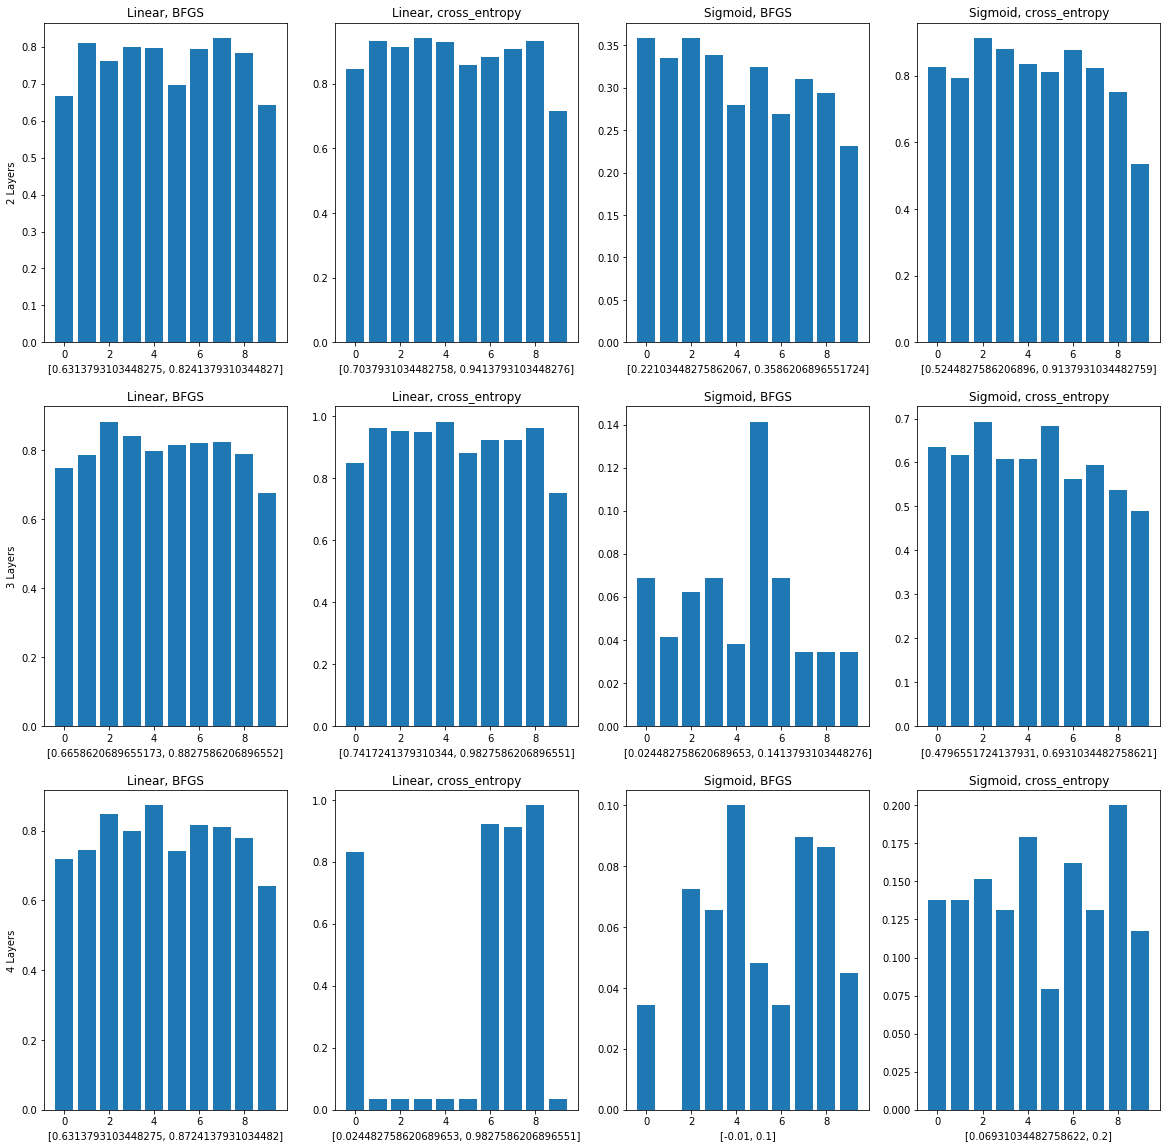

In [182]:
def hypertuning_plots(folds):
    plt.figure(figsize=(20,20))
    count = 0
    for i in range(12):
        count = count + 1
        plt.subplot(3,4,i+1)
        if count == 1 :
            plt.title('Linear, BFGS')
            if i == 0:
                plt.ylabel('2 Layers')
            elif i == 4:
                plt.ylabel('3 Layers')
            else: 
                plt.ylabel('4 Layers')
        elif count == 2:
            plt.title('Linear, cross_entropy')
        elif count == 3:
            plt.title('Sigmoid, BFGS')
        else:
            count = 0
            plt.title('Sigmoid, cross_entropy')
        plt.xlabel([min(folds[i])-0.01,max(folds[i])])
        plt.bar(range(len(folds[i])),folds[i])

hypertuning_plots(per_fold_eval_criteria_arrays)

With the left bound showing the lowest accuracy and the right bound showing the highest, we are then able to infer that our dataset performed best with neural network implementing linear, cross_entropy, and 3 layers.

<em>
<strong>[10 points]</strong> Visualize the magnitude of the gradients in each layer of the neural network versus the training iteration. Do the gradients stay consistent in each layer?
</em>

In [12]:
X_train = ds.data/255.0 - 0.5
y_train = ds.target_values

nn = MultiLayerPerceptron(**params, layers = 3, phi = 'linear', cost_function = 'cross_entropy')
nn.fit(X_train, y_train, print_progress=10)

Epoch: 100/100

MultiLayerPerceptron(C=None, alpha=0.001, cost_function='cross_entropy',
           decrease_const=0.0001, epochs=100, eta=0.0006105675350281862,
           layers=3, minibatches=50, n_hidden=50, phi='linear',
           random_state=None, shuffle=True)

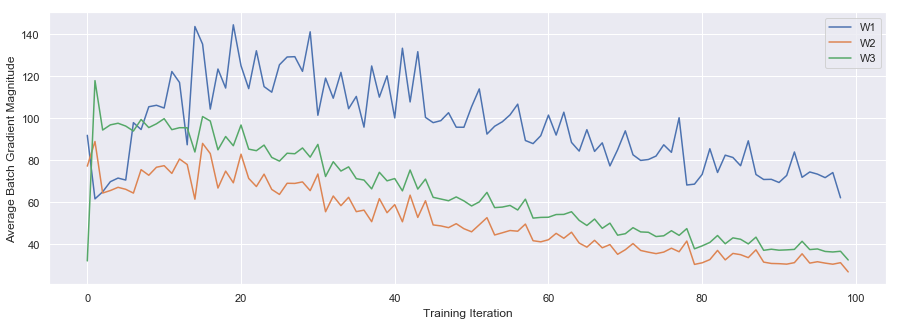

In [13]:
avg_grads_per_w = []
batch_count = 0
total_sum = 0
for i in range(nn.layers):
    avg_grad = []
    for j in range(len(nn.gradients)):
        if batch_count == nn.minibatches:
            total_sum /= nn.minibatches
            avg_grad.append(total_sum)
            batch_count = 0
            total_sum = 0
        total_sum += np.linalg.norm(nn.gradients[j][i])
        batch_count += 1
    avg_grads_per_w.append(avg_grad)

sns.set(style='darkgrid')

plt.figure(figsize=(15,5))
for i in range(nn.layers):
    label = 'W' + str(i+1)
    plt.plot(avg_grads_per_w[i], label=label)
plt.legend()
plt.ylabel('Average Batch Gradient Magnitude')
plt.xlabel('Training Iteration')
plt.show()

Ultimately, no. The gradients don't really stay the same in each layer. If we had more time to implement a better multilayer perceptron, we could have kept the gradients more uniform relative to one another and actually prevent unequal gradients. This could be done if we implemented an adaptive <strong>eta</strong>, which would maintain an inverse-proportional relationship between the gradients and eta, itself.

## Exceptional Work (10 points total)
<em>
    You have free reign to provide additional analyses.
One idea (required for 7000 level students):  Implement two more phi functions: ReLU and SiLU (also called Swish). Compare their performance to the linear and sigmoid phi functions. 
</em>

In [183]:
per_fold_eval_criteria_arrays2=[]
nn_arrays2=[]

nn_arrays2.append(MultiLayerPerceptron(**params, layers = 2, phi = 'relu', cost_function = 'bfgs'))
nn_arrays2.append(MultiLayerPerceptron(**params, layers = 2, phi = 'relu', cost_function = 'cross_entropy'))
nn_arrays2.append(MultiLayerPerceptron(**params, layers = 2, phi = 'silu', cost_function = 'bfgs'))
nn_arrays2.append(MultiLayerPerceptron(**params, layers = 2, phi = 'silu', cost_function = 'cross_entropy'))
nn_arrays2.append(MultiLayerPerceptron(**params, layers = 3, phi = 'relu', cost_function = 'bfgs'))
nn_arrays2.append(MultiLayerPerceptron(**params, layers = 3, phi = 'relu', cost_function = 'cross_entropy'))
nn_arrays2.append(MultiLayerPerceptron(**params, layers = 3, phi = 'silu', cost_function = 'bfgs'))
nn_arrays2.append(MultiLayerPerceptron(**params, layers = 3, phi = 'silu', cost_function = 'cross_entropy'))
nn_arrays2.append(MultiLayerPerceptron(**params, layers = 4, phi = 'relu', cost_function = 'bfgs'))
nn_arrays2.append(MultiLayerPerceptron(**params, layers = 4, phi = 'relu', cost_function = 'cross_entropy'))
nn_arrays2.append(MultiLayerPerceptron(**params, layers = 4, phi = 'silu', cost_function = 'bfgs'))
nn_arrays2.append(MultiLayerPerceptron(**params, layers = 4, phi = 'silu', cost_function = 'cross_entropy'))

my_scorer = make_scorer(accuracy_score)
cv=StratifiedKFold(n_splits=10)

for i in range(len(nn_arrays2)):   
    per_fold_eval_criteria_arrays2.append(cross_val_score(estimator=nn_arrays2[i],
                                    X=X_train,
                                    y=y_train,
                                    cv=cv,
                                    scoring=my_scorer
                                   ))

As seen before, the cell above is calculating the accuracy score for several different hyperparameter variations, this time between <strong>relu</strong> and <strong>silu</strong>. They are then all stored in an array to be plotted in our <strong>hypertuning_plots2</strong> function


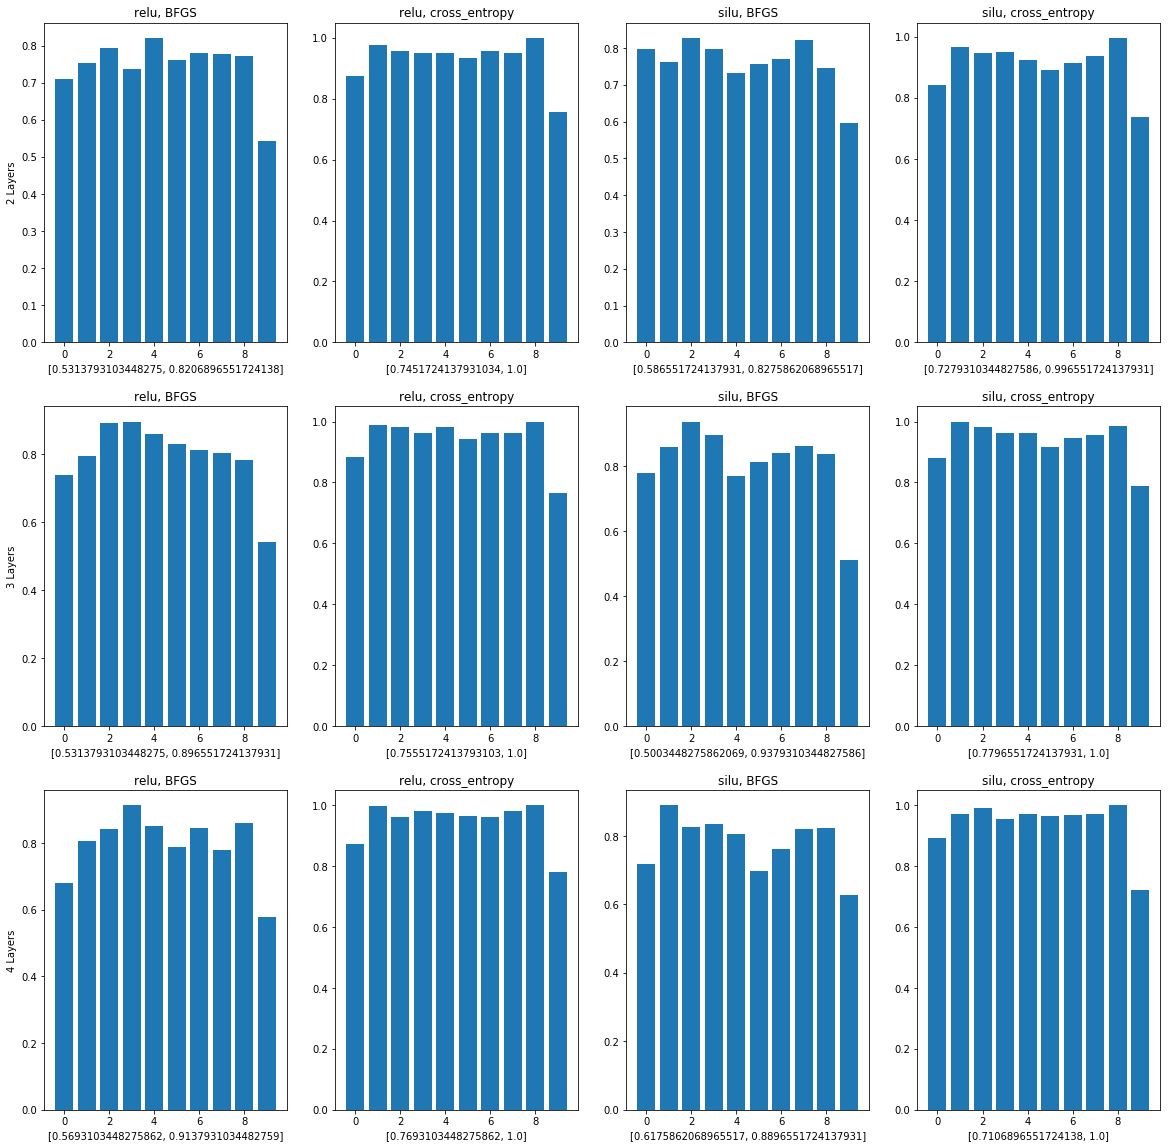

In [185]:
def hypertuning_plots2(folds):
    plt.figure(figsize=(20,20))
    count = 0
    for i in range(12):
        count = count + 1
        plt.subplot(3,4,i+1)
        if count == 1 :
            plt.title('relu, BFGS')
            if i == 0:
                plt.ylabel('2 Layers')
            elif i == 4:
                plt.ylabel('3 Layers')
            else: 
                plt.ylabel('4 Layers')
        elif count == 2:
            plt.title('relu, cross_entropy')
        elif count == 3:
            plt.title('silu, BFGS')
        else:
            count = 0
            plt.title('silu, cross_entropy')
        plt.xlabel([min(folds[i])-0.01,max(folds[i])])
        plt.bar(range(len(folds[i])),folds[i])

hypertuning_plots2(per_fold_eval_criteria_arrays2)

Using the same standard before with the left bound showing the lowest accuracy and the right bound showing the highest, we see that SiLu outperforms our previous linear model still using 3 layers and cross_entropy. This proves to ultimately be our model's best hyperparameters and in the real world we could expect to see an accuracy ballparked between 78% and 100%.